In [21]:
# Importing Packages and Libraries
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

In [22]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Utilitarian_Final.csv'
df = pd.read_csv(file_path)

In [23]:
# Drop unnecessary columns
columns_to_drop = ['title_x', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'text_cleaned',
       'text_cleaned1','main_category','features','prod_type','neutral_score','FRE']
df.drop(columns=columns_to_drop, inplace=True)

In [24]:
# Define features and target variable
features = ['rating', 'average_rating', 'rat_count', 'price', 'sentiment',
       'word_count', 'sent_count', 'sent_length', 'title_length',  'review_ext', 'elap_days',
       'image', 'year', 'month', 'hour', 'day_of_week', 'is_weekend', 'product', 'ver_purch', '#nouns',
       '#adj', '#adv', 'subjective_score']
target = 'helpful_ratio'

In [25]:
# Split data for test and training data
X_train, X_test, y_train, y_test = train_test_split(
    df[features],  
    df[target], 
    test_size=0.2,  # Adjusted
    random_state=42  # Set a random seed for reproducibility
)

In [26]:
# Define categorical and numerical features
categorical_features = ['product']
numerical_features = ['rating', 'average_rating', 'rat_count', 'price', 'sentiment',
                      'word_count', 'sent_count', 'sent_length', 'title_length', 'review_ext',
                      'elap_days', 'image', 'year', 'month', 'hour', 'is_weekend','ver_purch',
                      '#nouns', '#adj', '#adv', 'subjective_score']

# Convert 'product' column to categorical type
X_train['product'] = X_train['product'].astype('category')
X_test['product'] = X_test['product'].astype('category')

# Scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
       ("cat", OneHotEncoder(), ['product']),  # One-hot encode 'product'
       ("num", MinMaxScaler(), numerical_features),     # Scale numerical features
   ])

# Scale features
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Convert y_train and y_test to a 2D array
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Create an instance of MinMaxScaler for target variable
scaler = MinMaxScaler(feature_range=(0, 1))  # Set the feature range to be between 0 and 1

# Scale the target variable
scaled_y_train = scaler.fit_transform(y_train)
scaled_y_test = scaler.transform(y_test)

# Replace the original target variables with the scaled values
y_train = scaled_y_train
y_test = scaled_y_test

# Replace
x_train = X_train_scaled
x_test = X_test_scaled

In [27]:
# Train model with default hyperparameters
xgb_reg_default = xgb.XGBRegressor(objective='reg:pseudohubererror')

xgb_reg_default.fit(x_train, y_train)

# Predictions on test data
y_pred_default = xgb_reg_default.predict(x_test)

# Model evaluation
mse_default = mean_squared_error(y_test, y_pred_default)
mae_default = mean_absolute_error(y_test, y_pred_default)
print("\nDefault Model Evaluation:")
print(f"Mean Squared Error on Test Data: {mse_default}")
print(f"Mean Absolute Error on Test Data: {mae_default}")

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_reg_default, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_cv_mean = -cv_scores.mean()
print("Mean Cross-Validated MSE:", mse_cv_mean)


Default Model Evaluation:
Mean Squared Error on Test Data: 4.826097565245677e-05
Mean Absolute Error on Test Data: 0.0009856902956707982
Mean Cross-Validated MSE: 0.000134959910142254


In [28]:
# Get the column names of the numerical features
numerical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(numerical_features)

# Get the column names of the one-hot encoded categorical feature 'product'
categorical_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(['product'])

# Concatenate the numerical and one-hot encoded feature names
all_feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Create DataFrame from scaled X_train with the concatenated feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=all_feature_names)

In [29]:
# Get the column names of the numerical features
numerical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(numerical_features)

# Get the column names of the one-hot encoded categorical feature 'product'
categorical_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(['product'])

# Concatenate the numerical and one-hot encoded feature names
all_feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Create DataFrame from scaled X_train with the concatenated feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=all_feature_names)

## Shapley values

[18:13:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


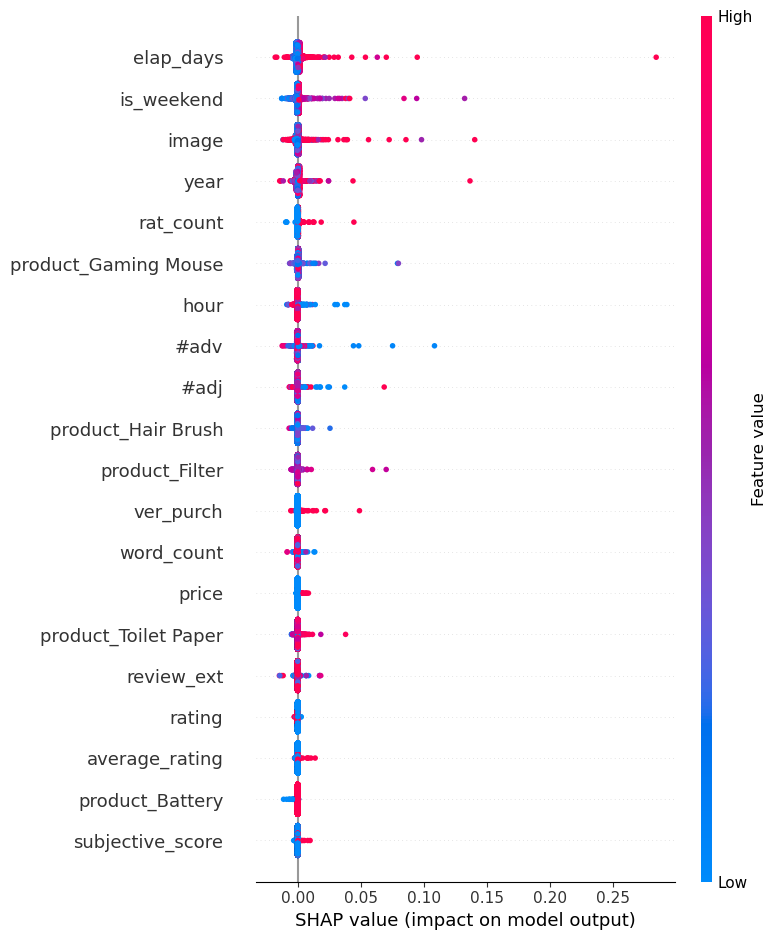

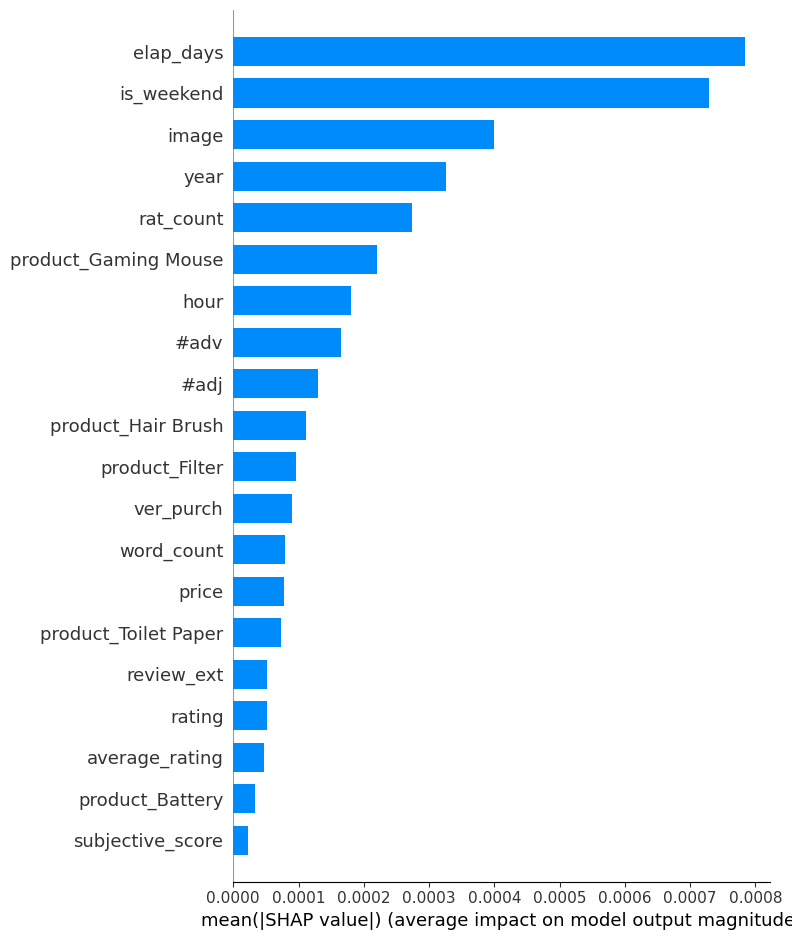

In [30]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_reg_default)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_scaled_df)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_scaled_df)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train_scaled_df, plot_type="bar", show=False)
plt.show()